# CESM-LE analysis
### Looks snow melt and runnoff dynamics from individual grid cells
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily H2OSNO & QRUNOFF over water year (Sept - Aug)
 - this script reads in summary data from daily output and does statistics 
    

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait

%matplotlib inline

### Fetch cluster

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='10GB')
cluster.scale(20) # roughly 20/ 5 ensemble members
#cluster.adapt(minimum_jobs=90, maximum_jobs=110)
# will need 110 to scale to all ensemble members

In [4]:
cluster

In [5]:
#client.restart()
#cluster.close()

### Read in  and concatinate dataset

In [7]:
pathIN = '/glade/scratch/wwieder/VernalWindow/SnowStatsSWE*.nc'
ds = xr.open_mfdataset(pathIN,combine='nested',parallel=True,
                                    concat_dim=['ens']).persist()
_ = wait(ds)
print(' -- Data read in -- ')

 -- Data read in -- 


In [8]:
# Need to make last year of runoff variables zero
qvars = ['MaxQrun','MaxQrunDate','TotQrun','WinMELT','f_WinMELT']
for i in range(len(qvars)):
    ds[qvars[i]] = ds[qvars[i]].where(ds.time<2100)
    
# set day of first and last snow to day of water years
#svars = ['LastSnowFree','FirstSnowFree']
#for i in range(len(svars)):
#    ds[svars[i]] = ds[svars[i]]+92
#    ds[svars[i]] = ds[svars[i]].where(ds[svars[i]]<365, ds[svars[i]]-365)
#    ds[svars[i]].attrs['long_name'] = svars[i]

ds['SnowFree'].attrs['long_name'] = "Snow free days"

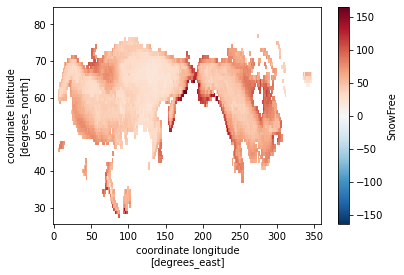

In [44]:
#Mask out missing values (again)
ds = ds.where(ds['SnowFree']>=0)
(ds.SnowFree.isel(time=-1)-ds.SnowFree.isel(time=0)).mean('ens').plot();

--------------
### Calculate ensemble means, stats and time of emergence

In [11]:
%%time
# ensemble mean of annual data
ds_ensMean = ds.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = ds.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

# add attributes
for ii in ds.data_vars:
    ds_ensMean[ii].attrs = ds[ii].attrs
    ds_ensStd[ii].attrs = ds[ii].attrs

CPU times: user 717 ms, sys: 703 ms, total: 1.42 s
Wall time: 10.8 s


### Length of snow free season & change over time

In [12]:
def changePlots (plotVar,vmin1=0,vmax1=350,cmap2='OrRd'):
    f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')

    # 1850's 
    ax1.set_title(ds_ensMean[plotVar].attrs['long_name']+", 1850's",
                  loc='left', fontsize='large', fontweight='bold')
    ds_ensMean[plotVar].isel(time=slice(0,10)).mean('time').plot(
        ax=ax1, vmax=vmax1, vmin=vmin1,
        cbar_kwargs={'label': ds_ensMean[plotVar].attrs['long_name']}) ;
    ax1.set_xlabel('')
    ax1.set_ylabel('')

    # 2100 
    ax2.set_title(ds_ensMean[plotVar].attrs['long_name']+", 2090's",
                  loc='left', fontsize='large', fontweight='bold')
    ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time').plot(
        ax=ax2, vmax=vmax1, vmin=vmin1,
        cbar_kwargs={'label': ds_ensMean[plotVar].attrs['long_name']}) ;
    ax2.set_xlabel('')
    ax2.set_ylabel('')

    # Change 2100 - 1901
    ax3.set_title("Change "+ds_ensMean[plotVar].attrs['long_name']+", 2090's-1850's",
                  loc='left', fontsize='large', fontweight='bold')
    temp = ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time') - \
           ds_ensMean[plotVar].isel(time=slice(  0,10  )).mean('time')
    temp.plot(
        ax=ax3, robust=True,#vmax=120,vmin=0, 
        cbar_kwargs={'label': 'Change '+ds_ensMean[plotVar].attrs['long_name']},cmap=cmap2) 
    ax3.set_ylabel('') 
    ax3.set_xlabel('') ; 

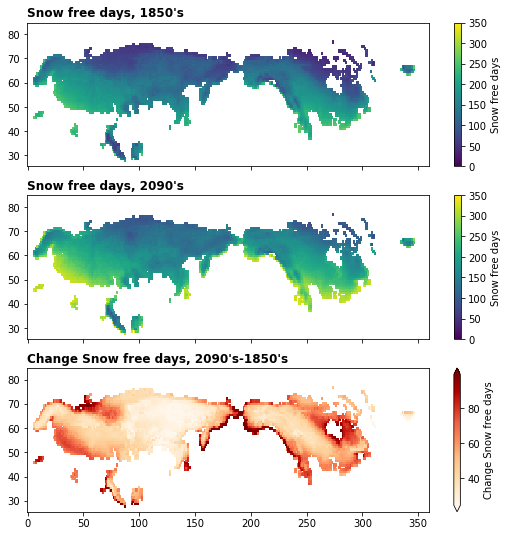

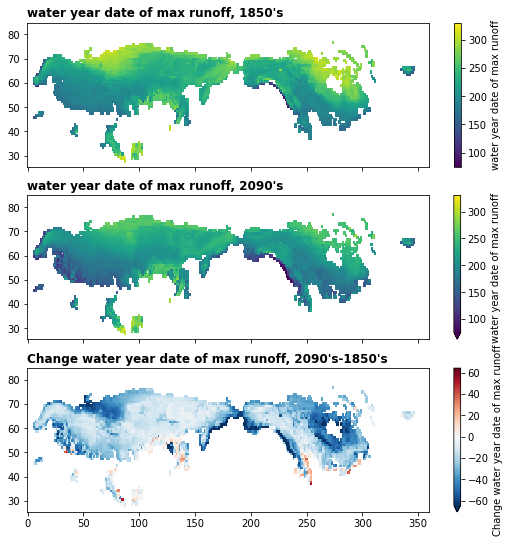

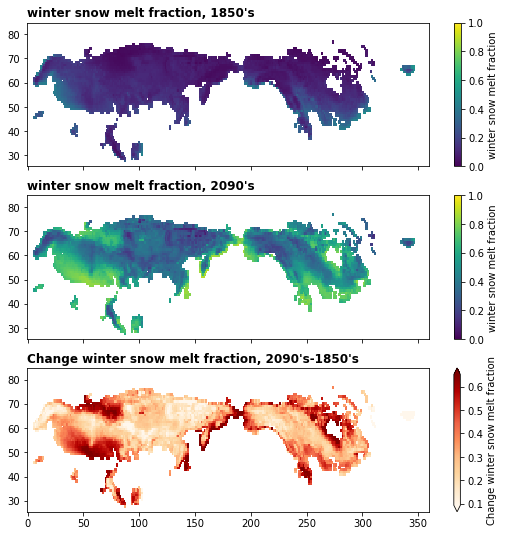

In [13]:
changePlots('SnowFree',cmap2='OrRd')
changePlots('MaxQrunDate',75,330,cmap2='RdBu_r')
changePlots('f_WinMELT',0,1,cmap2='OrRd')


### Different plots to look at regional changes 

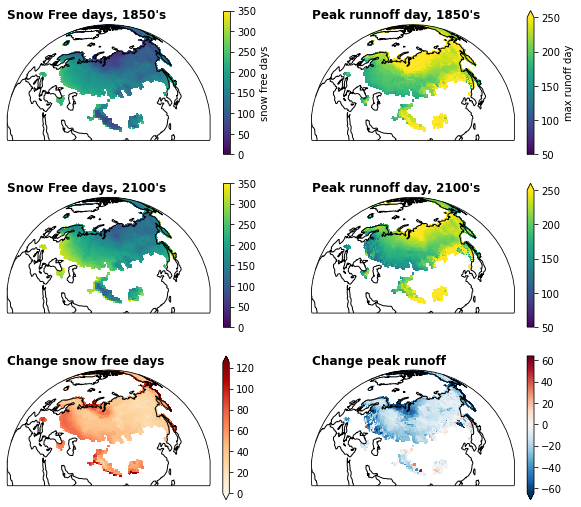

In [14]:
# Number of snow free days
plotVar = ['SnowFree','MaxQrunDate']
lat,lon,region,ortho = [25,80], [0,360], 'Europe', [80,30]
#lat,lon,region,ortho = [35,85], [0,360], 'W. NA',[-100,30]
dsWest =  ds_ensMean.sel(lat=slice(lat[0],lat[1]), lon=slice(lon[0],lon[1]))

f, ((ax1, ax2),(ax3, ax4),(ax5,ax6))= plt.subplots(
    3,2, figsize=(10, 9),sharey='row',sharex='col',
    subplot_kw=dict(projection=ccrs.Orthographic(ortho[0], ortho[1])) )

# free days 1901 
ax1.set_title("Snow Free days, 1850's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[0]].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': 'snow free days'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.coastlines()  # cartopy function

ax2.set_title("Peak runnoff day, 1850's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[1]].isel(time=slice(0,10)).mean('time').plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': 'max runoff day'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.coastlines()  # cartopy function

# free days 2100 
ax3.set_title("Snow Free days, 2100's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[0]].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': ''}) ;
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.coastlines()  # cartopy function

ax4.set_title("Peak runnoff day, 2100's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[1]].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax4,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': ''}) ;
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.coastlines()  # cartopy function

# Change  2100 - 1901
ax5.set_title("Change snow free days",loc='left', 
              fontsize='large', fontweight='bold')
(dsWest[plotVar[0]].isel(time=slice(-10,None)).mean('time') - 
 dsWest[plotVar[0]].isel(time=slice(  0,10  )).mean('time')).plot(
    ax=ax5,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=125,vmin=0, cbar_kwargs={'label': ''},cmap='OrRd') ;
ax5.set_xlabel('')
ax5.set_ylabel('')
ax5.coastlines()  # cartopy function

ax6.set_title("Change peak runoff ",loc='left', 
              fontsize='large', fontweight='bold')
(dsWest[plotVar[1]].isel(time=slice(-10,None)).mean('time') - 
 dsWest[plotVar[1]].isel(time=slice(  0,  10)).mean('time')).plot(
    ax=ax6,
    transform=ccrs.PlateCarree(),  # this is important!
    robust=True, cbar_kwargs={'label': ''},cmap='RdBu_r') ;
ax6.set_xlabel('')
ax6.set_ylabel('')  
ax6.coastlines() ;  # cartopy function

--------------
## Time of emergence & variability stats
- Start by looking at a single gridcell

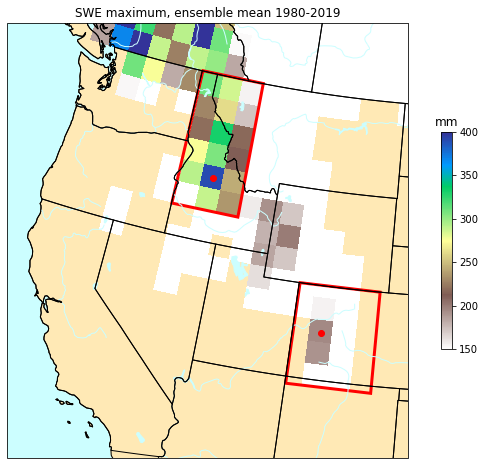

In [15]:
#plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat,plot,site  = 38, 360-108, 'Telluride, CO'
plat = [39,44.7]
plon = [252.5,360-115]
site = ['Crested Butte, CO','Frank Church Wilderness, ID']
ftime, ltime = 130, 169 # select time window to plot
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

sno_vars = ['MaxSnow','LastSnowFree','FirstSnowFree',
            'SnowFree','MaxQrun','MaxQrunDate','TotQrun',
           'f_WinMELT']
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

#plat2 = [40.0, 39 ]  
#plon2 = [(360-105.4), 253]

conus_proj = ccrs.LambertConformal(central_longitude=-96,central_latitude=39.0)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=conus_proj)
ax.set_extent([-123,-104,34,50])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAKES, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')

# -- draw box around S. Rockies -- 
#104–109°W, 37–41°N
lat_corners = np.array([36.7,  36.7, 41, 41])
lon_corners = np.array([ (360-109), (360-104.5), (360-104.5), (360-109)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- draw box around N. Rockies -- 
lat_corners = np.array([43.3,  43.3, 49, 49])
lon_corners = np.array([ (360-117), (360-113.1), (360-113.1), (360-117)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- filled contours, max snow from single ensemble in first decade ==
cf = ax.pcolormesh(ds.lon, ds.lat, ds.MaxSnow.isel(time=slice(ftime,ltime)).mean(dim=['time','ens']), 
                   vmin=150,vmax=400, cmap='terrain_r',
                   transform=ccrs.PlateCarree());
#cf = ax.pcolormesh(dsREG2.lon, dsREG2.lat, dsREG2.H2OSNO.isel(ens=1, time=slice(0,120)).max(dim='time'), 
#                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('mm')
ax.set_title("SWE maximum, ensemble mean "+
             str(ds.time.isel(time=ftime).values)+"-"+
             str(ds.time.isel(time=ltime).values));
plt.plot(plon, plat,
         color='red', linewidth=0, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.show()

#dsREG.H2OSNO.max(dim='time').isel(ens=1).plot(robust=True)
#dsREG = dsREG.mean(dim=['lat','lon'])


In [16]:
# Todo this would be better to generate a table,
#    but for now I'll just copy it into a sheet for Keith...
for i in range(3):
    if i <2:
        print(site[i])
        for v in range(len(sno_vars)):
            print(ds_ensMean[sno_vars[v]].sel(
                lat = plat[i], lon = plon[i], method='nearest'
            ).mean('time').values )
        print('mean of ens STD')
        for v in range(len(sno_vars)):
            print(ds_ensStd[sno_vars[v]].sel(
                lat = plat[i], lon = plon[i], method='nearest'
            ).mean('time').values )
    else: 
        for v in range(len(sno_vars)):
            print(sno_vars[v])

Crested Butte, CO
178.25246
45.6816733067729
189.10089641434263
221.5807768924303
5.665312183114168
184.5579
282.0866080747901
0.25346145
mean of ens STD
55.326084
9.55331058175304
10.595658553303249
14.48880665423901
2.11706359636845
17.097704267321546
83.25543849674229
0.15249549
Frank Church Wilderness, ID
361.1074
37.103187250996015
211.11155378486055
190.2645418326693
11.229274191804496
187.1412
532.9793858162337
0.20936872
mean of ens STD
109.26352
13.818852800454216
13.203047316694082
17.128852986385237
3.2469569434159644
11.998060799260042
128.4945899707748
0.120900236
MaxSnow
LastSnowFree
FirstSnowFree
SnowFree
MaxQrun
MaxQrunDate
TotQrun
f_WinMELT


<Figure size 1008x792 with 0 Axes>

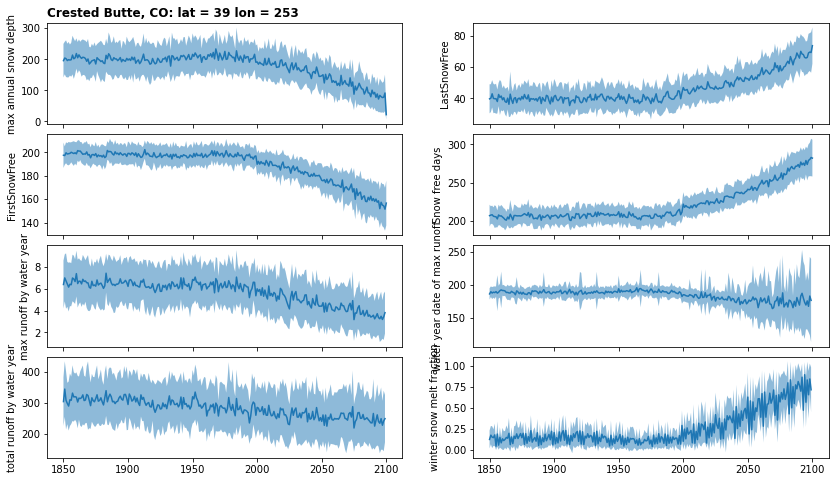

In [17]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
plt.figure(figsize=[14,11])
fig, axs = plt.subplots(4,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,8))
i,j = 0,0
for v in range(len(sno_vars)):
    x = ds_ensMean.time
    y = ds_ensMean[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
        
    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(ds[sno_vars[v]].attrs['long_name']) ;
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') 
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0

## Flavio defined ToE as time when 10 year running mean > baseline
#### Here we'll take: 
- 30 year baseline (1850-1880)
- 10 year running mean

In [18]:
# ensemble mean and std over first 30 years
dsBase    = ds.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = ds.isel(time=slice(0,30)).std(dim=['time','ens']).compute()

#### Take 10 year rolling mean of each ensemble, then take ensemble statistics.

In [19]:
%%time 
#roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
ds_roll = ds.rolling(time=10, center=True).mean().compute()
print(ds_roll)
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()

<xarray.Dataset>
Dimensions:        (ens: 40, lat: 63, lon: 288, time: 251)
Coordinates:
  * time           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 25.92 26.86 27.8 28.74 ... 82.46 83.4 84.35
  * ens            (ens) int64 10 11 12 13 14 15 16 17 ... 43 44 45 46 47 48 49
    year           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
Data variables:
    MaxSnow        (ens, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    MaxQrun        (ens, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    TotQrun        (ens, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    TotMELT        (ens, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    WinMELT        (ens, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    f_WinMELT      (ens, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    MaxQrun

#### Plot: 
* ensemble mean & standard deviation
* rolling mean & rolling std
* base mean and std (all ensembles over first 20 years)

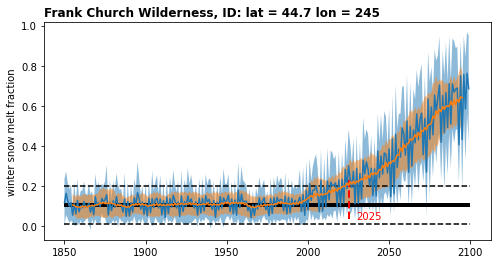

In [20]:
#plat, plon, site =  39 , 253  , 'Crested Butte, CO'
#plat,plot,site  = 38, 360-108, 'Telluride, CO'
plat,plon,site = 44.7, 360-115, 'Frank Church Wilderness, ID'
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
testVar = 'f_WinMELT'
plt.figure(figsize=[8,4])
x = ds_ensMean.time
y = ds_ensMean[testVar].sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd[testVar].sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, y - y2, y + y2, alpha=0.5)
plt.ylabel(ds[testVar].attrs['long_name']) ;

x = roll_ensMean.time
y = roll_ensMean[testVar].sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd[testVar].sel(lat = plat, lon = plon, method='nearest')
plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

plt.hlines(dsBase[testVar].sel(lat = plat, lon = plon, method='nearest'), 1850, 2100, colors='k',lw=4) ;
plt.hlines((dsBase[testVar] + dsBaseStd[testVar]).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') ;
plt.hlines((dsBase[testVar] - dsBaseStd[testVar]).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') 
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = test.where(test<dsBase[testVar].sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1)
plt.vlines(ToE, test.min()*0.95,test.max()*2.2,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;

#### Test code for all variables

<Figure size 1008x792 with 0 Axes>

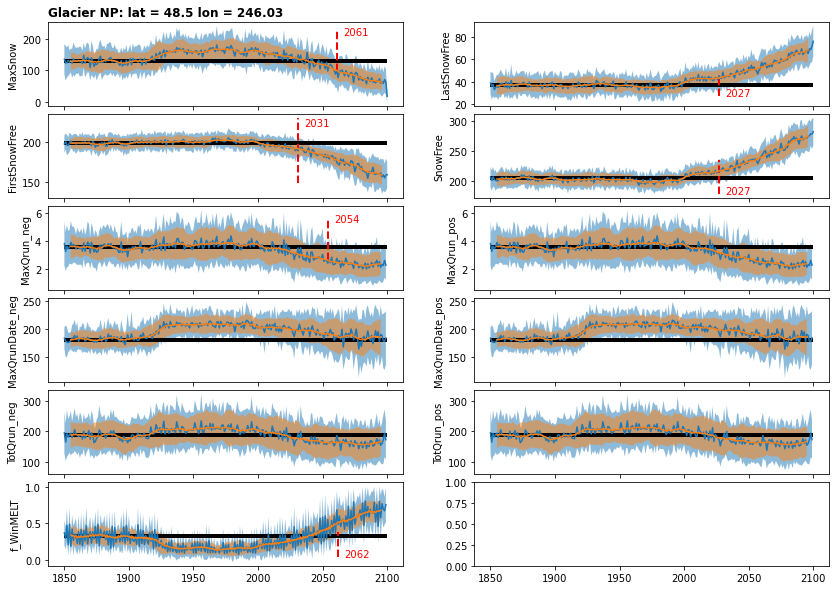

In [21]:
#plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
#plat, plon, site =  64 , 12.1  , 'Random point' 
#plat, plon, site =  40.45, 360-105.75, 'Rocky Mountain NP'
#plat, plon, site =  44.66, 360-111.09, 'Yellowstone NP'
plat, plon, site =  48.5 , 360-113.97,  'Glacier NP'
#plat,plot,site  = 38, 360-108, 'Telluride, CO'
#plat,plon,site = 44.7, 360-115, 'Frank Church Wilderness, ID'

in_vars = ['MaxSnow','LastSnowFree',
           'FirstSnowFree','SnowFree',
           'MaxQrun','MaxQrun',
           'MaxQrunDate','MaxQrunDate',
           'TotQrun','TotQrun',
          'f_WinMELT']
sno_vars = ['MaxSnow','LastSnowFree',
            'FirstSnowFree','SnowFree',
            'MaxQrun_neg','MaxQrun_pos',
            'MaxQrunDate_neg','MaxQrunDate_pos',
            'TotQrun_neg','TotQrun_pos','f_WinMELT']
sno_trend = ['neg','pos',
             'neg','pos',
             'neg','pos',
             'neg','pos',
             'neg','pos','pos']
plt.figure(figsize=[14,11])
fig, axs = plt.subplots(6,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,10))
i,j = 0,0
for v in range(len(sno_vars)):
    # ens mean
    x = ds_ensMean.time
    y = ds_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')

    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(sno_vars[v]) ;

    # rolling ensemble mean
    x = roll_ensMean.time
    y = roll_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2= roll_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    axs[i,j].plot(x, y)
    axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

    # baseline
    axs[i,j].hlines(dsBase[in_vars[v]].sel(
        lat = plat, lon = plon, method='nearest'), 
                    1850, 2100, colors='k',lw=4) ;

    # find last day when roll mean - 2 std < baseline
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        test = y - 2*y2
        test = test.where(test<dsBase[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')
    else:
        test = y + 2*y2
        test = test.where(test>dsBase[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')

    ToE = test.time.isel(time=-1)
    #draw ToE lines
    if ToE <2095:
        if sno_trend[v] == 'pos': 
            axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.15,colors='r',
                            lw=2,linestyles='dashed') ;
            axs[i,j].text(ToE+5, test.min()*0.95, ToE.values,color='r')
        else: 
            axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.1,colors='r',
                            lw=2,linestyles='dashed') ;
            axs[i,j].text(ToE+5, test.max()*1.05, ToE.values,color='r')
    # Add title
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0 ;

Repeat above with a subset of variables: & over a shorter window (1960-2020)
# rebase 1950-1969 mean

In [22]:
# ensemble mean and std over first 30 years
dsBase20    = ds.isel(time=slice(100,120)).mean(dim=['time','ens']).compute()
dsBase20Std = ds.isel(time=slice(100,120)).std(dim=['time','ens']).compute()
print(ds.time.isel(time=slice(100,120)))

<xarray.DataArray 'time' (time: 20)>
array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969])
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 1965 1966 1967 1968 1969
    year     (time) int64 dask.array<chunksize=(20,), meta=np.ndarray>


<Figure size 1152x432 with 0 Axes>

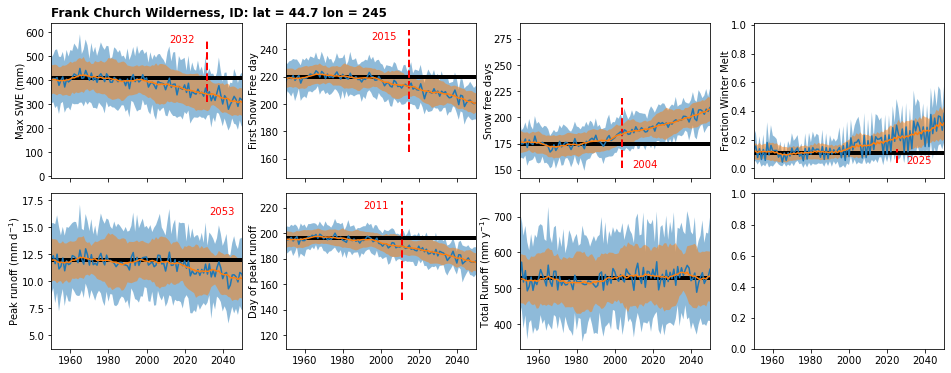

In [23]:
#plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
#plat, plon, site =  64 , 12.1  , 'Random point' 
#plat, plon, site =  40.45, 360-105.75, 'Rocky Mountain NP'
#plat, plon, site =  44.66, 360-111.09, 'Yellowstone NP'
#plat, plon, site =  48.5 , 360-113.97,  'Glacier NP'
#plat,plot,site  = 38, 360-108, 'Telluride, CO'
plat,plon,site = 44.7, 360-115, 'Frank Church Wilderness, ID'



in_vars = ['MaxSnow','FirstSnowFree','SnowFree','f_WinMELT',
           'MaxQrun','MaxQrunDate','TotQrun']
sno_vars = ['Max SWE (mm)', 'First Snow Free day',
            'Snow free days', 'Fraction Winter Melt',
            'Peak runoff (mm $\mathregular{d^{-1}}$)',
            'Day of peak runoff',
            'Total Runoff (mm $\mathregular{y^{-1}}$)']
sno_trend = ['neg','neg','pos','pos',
             'neg','neg','neg']
plt.figure(figsize=[16,6])
fig, axs = plt.subplots(2,4, sharex=True,
                        gridspec_kw={'wspace': 0.23, 'hspace': 0.1},
                        figsize=(16,6))
i,j = 0,0
for v in range(len(sno_vars)):
    # ens mean
    x = ds_ensMean.time
    y = ds_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')

    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(sno_vars[v],labelpad=0.) ;

    # rolling ensemble mean
    x = roll_ensMean.time
    y = roll_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2= roll_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    axs[i,j].plot(x, y)
    axs[i,j].set_xlim(1950,2050)
    axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

    # baseline
    axs[i,j].hlines(dsBase20[in_vars[v]].sel(
        lat = plat, lon = plon, method='nearest'), 
                    1950, 2050, colors='k',lw=4) ;

    # find last day when roll mean - 2 std < baseline
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        test = y - 2*y2
        test = test.where(test<dsBase20[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')
    else:
        test = y + 2*y2
        test = test.where(test>dsBase20[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')

    ToE = test.time.isel(time=-1)

    if sno_trend[v] == 'pos': 
        axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.25,colors='r',
                        lw=2,linestyles='dashed') ;
        axs[i,j].text(ToE+5, test.min()*0.95, ToE.values,color='r')
    else: 
        axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.1,colors='r',
                        lw=2,linestyles='dashed') ;
        axs[i,j].text(ToE-20, test.max()*1.07, ToE.values,color='r')
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;
    # move counter for panel
    j = j+1
    if j == 4:
        i = i+1
        j = 0 ;

#### Time of emergence globally

In [24]:
# Back to big list of variables

in_vars = ['MaxSnow','LastSnowFree','FirstSnowFree',
           'SnowFree','f_WinMELT','f_WinMELT',
           'MaxQrun','MaxQrun',
           'MaxQrunDate','MaxQrunDate',
           'TotQrun','TotQrun']
sno_vars = ['MaxSnow','LastSnowFree','FirstSnowFree',
            'SnowFree','f_WinMELT_pos','f_WinMELT_neg',
            'MaxQrun_neg','MaxQrun_pos',
            'MaxQrunDate_neg','MaxQrunDate_pos',
            'TotQrun_neg','TotQrun_pos']
sno_trend = ['neg','pos','neg',
             'pos','pos','neg',
             'neg','pos',
             'neg','pos',
             'neg','pos']

In [25]:
import cartopy.crs as ccrs
# find ToE for Snow free days when roll mean - 2 std < baseline
test = roll_ensMean.SnowFree - 2*roll_ensStd.SnowFree
test = test.where(test<dsBase.SnowFree)
GOI = (test.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
print(GOI.time.max())#isel(time=-1))
#GOI.plot()

test.time.max()#.groupby()['time'].max()
#test.time.dropna('time').plot()
#test = test.idxmax(dim='time')
#test.where(test>1850).sel(lon=slice(5,44),lat=slice(50,77)).plot(    
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={
    #    "projection": ccrs.LambertConformal(
    #        central_longitude=0, central_latitude=60
    #    )
    #},
#    robust=True) ;
#print(test)

<xarray.DataArray 'time' ()>
array(2009)
Coordinates:
    lon      float32 245.0
    lat      float32 44.76


<xarray.DataArray 'time' ()>
array(2100)

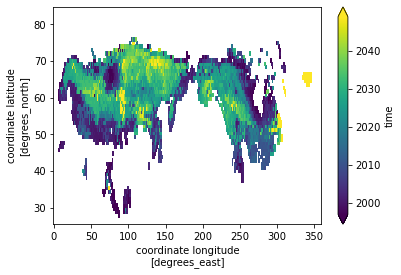

In [26]:
ToE_coords = test.coords
ToE = xr.Dataset(coords=ToE_coords)

for v in range(len(sno_vars)):
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        temp = roll_ensMean[in_vars[v]] - 2*roll_ensStd[in_vars[v]]
        temp = temp.time.where(temp<dsBase[in_vars[v]])
    else:
        temp = roll_ensMean[in_vars[v]] + 2*roll_ensStd[in_vars[v]]
        temp = temp.time.where(temp>dsBase[in_vars[v]])
    
    if v == 3:
        #print(temp.max(dim='time'))
        temp.max(dim='time').plot(robust=True)
    ToE[sno_vars[v]] = temp.max(dim='time')

    ToE = ToE.where(ToE>1850)
    ToE = ToE.where(ToE<2095)

In [27]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None, units=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,25,85], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.05, fraction = 0.1, orientation='horizontal')
        cbar.set_label(units)
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units)


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


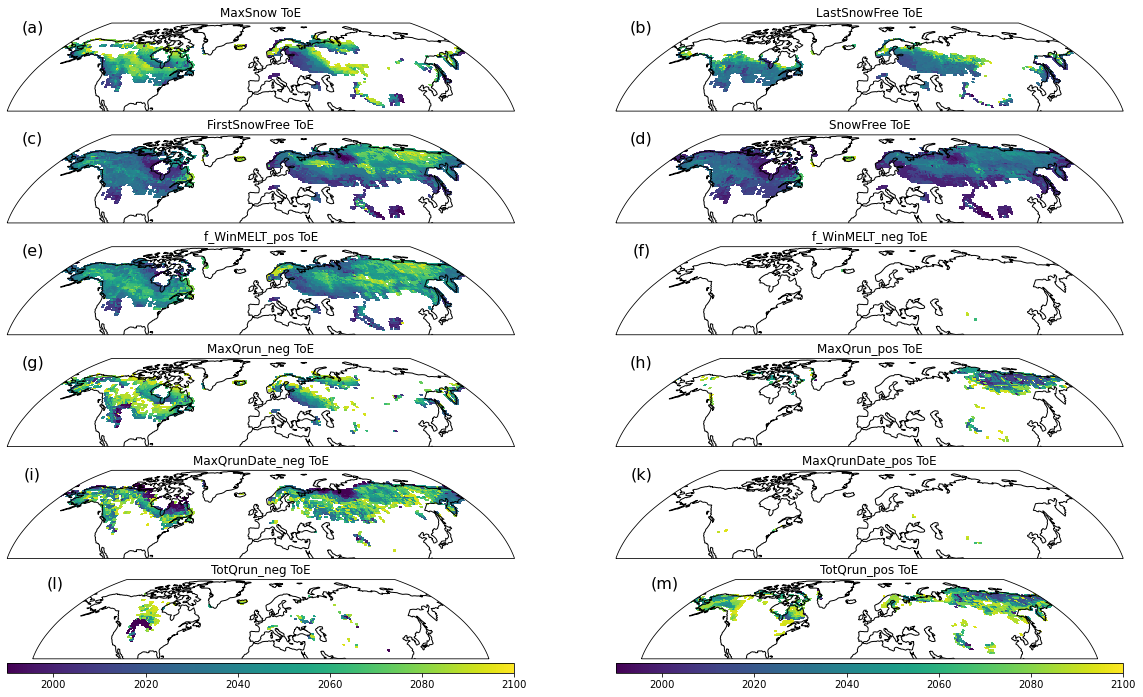

In [28]:
# Now call the map_function
#---------------------
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)',
         '(h)','(i)','(k)','(l)','(m)','(n)']  

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,12), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,0,0,0,0,0,0,0,0,1,1]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = ToE[sno_vars[i]]
    map_function(da, panel=panel[i], ax=ax, title=sno_vars[i]+' ToE', 
                 vmin=1990, vmax=2100, cb=cb[i])

    i = i+1

# or to provide a common color bar, set vmax/min so same values and 
#fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5);
#plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_3c_GPP_DTcorr.eps')


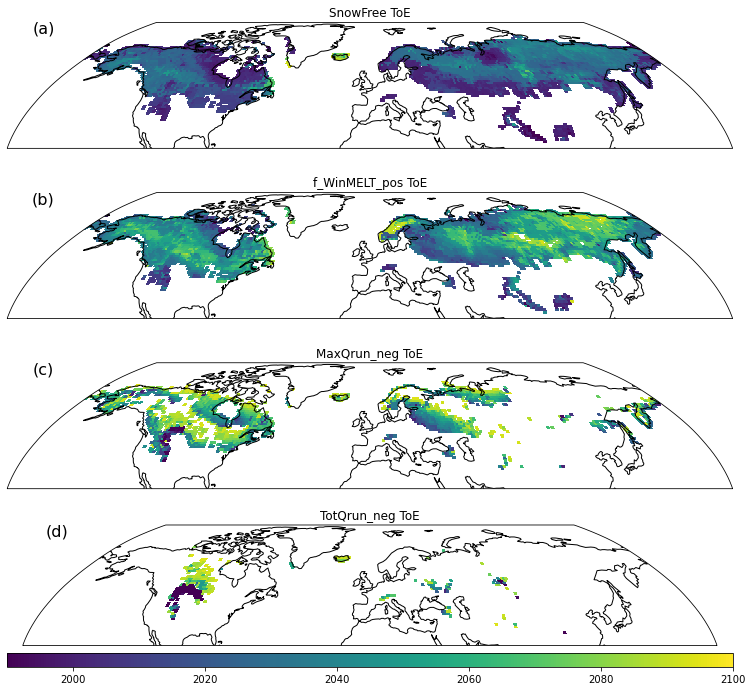

In [29]:
#removed 'LastSnow',
pltVars = ['SnowFree','f_WinMELT_pos','MaxQrun_neg','TotQrun_neg']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(13,12), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,0,1]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    map_function(ToE[pltVars[i]], panel=panel[i], ax=ax, title= pltVars[i]+' ToE', 
                 cb=cb[i], vmin=1990, vmax=2100) 

    i = i+1



## Plot mean change, stdev change and TOE for individual variables
- TODO, check this is accurate, change in SD, relative to initial SD, averaged over ensembles?


In [75]:
meanFIN = ds.isel(time=slice(-20,None)).mean('time')
meanINI = ds.isel(time=slice(  0,20  )).mean('time')
sdFIN = ds.isel(time=slice(-20,None)).std('time')
sdINI = ds.isel(time=slice(  0,20  )).std('time')
meanChange = (meanFIN-meanINI).mean('ens').compute()
sdChange = 100*((sdFIN-sdINI)/sdINI).mean('ens').compute()


# add attributes
for ii in meanChange.data_vars:
    meanChange[ii].attrs = ds[ii].attrs
    sdChange[ii].attrs = ds[ii].attrs
    


In [99]:
# Get all signficant ToE Value (pos or neg)
ToE['MaxQrunDate'] = ToE.MaxQrunDate_neg.where(ToE.MaxQrunDate_neg.notnull(),ToE.MaxQrunDate_pos)
ToE['TotQrun'] = ToE.TotQrun_neg.where(ToE.TotQrun_neg.notnull(),ToE.TotQrun_pos)
#Fill ToE with NA when it never occurs
#    ToE = ToE.where(ToE<2095)
#meanChange.f_WinMELT

KeyboardInterrupt: 

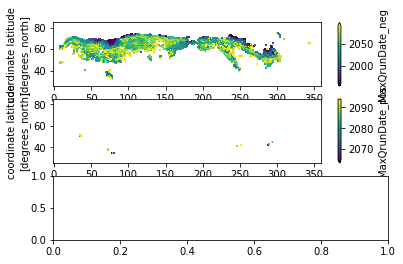

In [96]:
tempVar = 'SnowFree'
plt.subplot(311)
a = ds[tempVar].isel(time=slice(0,20)).mean('time')
a.mean('ens').plot(robust=True)
plt.subplot(312)
b = ds[tempVar].isel(time=slice(-20,None)).mean('time')
b.mean('ens').plot(robust=True)
plt.subplot(313)
c = b-a
c.mean('ens').plot(robust=True)
#meanChange[tempVar].attrs

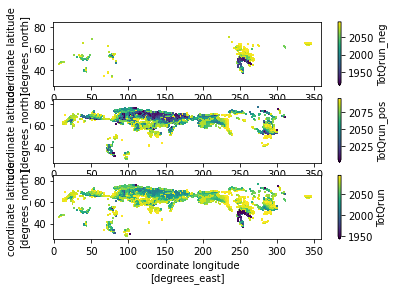

In [100]:
plt.subplot(311)
ToE.TotQrun_neg.plot(robust=True)

plt.subplot(312)
ToE.TotQrun_pos.plot(robust=True)

plt.subplot(313)
ToE.TotQrun.plot(robust=True)

In [78]:
panel2 = [['(a)','(c)','(e)'],['(b)','(d)','(f)']]
panel2[0][1]

'(c)'

In [79]:
#ds.SnowFree.isel(time=slice(0,None)).mean(['time','ens']).plot()

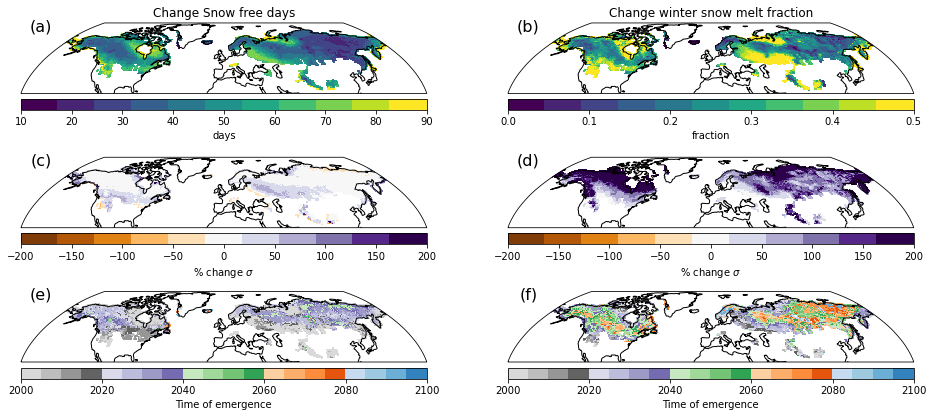

In [102]:
pltData = ['ensemble mean change','ensemble standard deviation change','time of emergence ']

pltVars = ['SnowFree','f_WinMELT']
ToEVars = ['SnowFree','f_WinMELT_pos']

#pltVars = ['MaxQrunDate','TotQrun']
#ToEVars =['MaxQrunDate_neg','TotQrun']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,7), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

# loop over plots to make
j = 0 #select variable
i = 0 # plot/panel counter

for j in range(2):
    #Define range, colorbar and units for variables
    
    if j == 0:
        vmin, vmax = [10,-200,2000], [90 ,200 ,2100]
        cmapOptA = cm.get_cmap('viridis', 11)
        cmapOptB = cm.get_cmap('PuOr', 11)
        units = 'days'
    if j == 1:
        vmin, vmax = [0,-200,2000], [0.5 ,200 ,2100]
        cmapOptA = cm.get_cmap('viridis', 11)
        cmapOptB = cm.get_cmap('PuOr', 11)
        units = 'fraction'

    '''
    if j == 0:
        vmin, vmax = [-50,-200,2000], [50 ,200 ,2100]
        cmapOptA = cm.get_cmap('PuOr', 11)
        cmapOptB = cm.get_cmap('PuOr', 11)
        units = 'days'
    if j == 1:
        vmin, vmax = [-200,-200,2000], [200 ,200 ,2100]
        cmapOptA = cm.get_cmap('PuOr', 11)
        cmapOptB = cm.get_cmap('PuOr', 11)
        units = 'mm $\mathregular{y^{-1}}$'
    '''
    for i in range(3):
        #i = index[0]
        if i ==0: 
            dataIn = meanChange[pltVars[j]]
            cmap   = cmapOptA  
            units  = units
            title  = 'Change '+meanChange[pltVars[j]].attrs['long_name']
        if i ==1: 
            dataIn = sdChange[pltVars[j]]
            cmap   = cmapOptB
            units  = '% change '+r'$\sigma$'
            title  = None
        if i ==2: 
            dataIn = ToE[ToEVars[j]]
            cmap   = 'tab20c_r'
            units  = 'Time of emergence'
            title  = None
        # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
        map_function(dataIn, panel=panel2[j][i], ax=axs[i,j], 
                     title= title, 
                     vmax = vmax[i], vmin = vmin[i], cmap=cmap,
                     cb=1, units=units) 


In [ ]:
plotVar = 'MaxQrunDate'
ds_ensStd[plotVar].isel(time=[10,-11]).plot(y='lat',x='lon',col="time",
                                            col_wrap=2, robust=True,
                                            cbar_kwargs={"label": plotVar+" StDev",
                                            "pad": 0.05 }  # passed to plt.colorbar
                                           ) ;

In [ ]:
plotVar = 'MaxQrunDate'
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,1]
timePlot= [10,-11]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    year = str(ds_ensStd.time.isel(time=10).values)
    map_function(ds_ensStd[plotVar].isel(time=timePlot[i]), 
                 panel=panel[i], ax=ax, 
                 title= plotVar + ' StDev ' +
                        str(ds_ensStd.time.isel(time=timePlot[i]).values), 
                 cb=cb[i], vmin=0, vmax=75) 

    i = i+1

In [ ]:
# Change in max runoff date std
plotVar = 'MaxQrunDate'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
# free days 1850's 
ax1.set_title(plotVar+" StDev, 1850's",loc='left', fontsize='large', fontweight='bold')
ds_ensStd[plotVar].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1, vmax=75, vmin=0,
    cbar_kwargs={'label': plotVar+' StDev'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
ax2.set_title(plotVar+" StDev, 2090's",loc='left', fontsize='large', fontweight='bold')
ds_ensStd[plotVar].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax2, vmax=75, vmin=0,
    cbar_kwargs={'label': plotVar+' StDev'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title("Change "+plotVar+" StDev, 2090's-1850's",loc='left', fontsize='large', 
              fontweight='bold')
temp = ds_ensStd[plotVar].isel(time=slice(-10,None)).mean('time') - \
       ds_ensStd[plotVar].isel(time=slice(  0,10  )).mean('time')
temp.plot(
    ax=ax3, vmax=50, vmin=-50, 
    cbar_kwargs={'label': 'Change '+plotVar+' stdev'},cmap='RdBu_r') 
ax3.set_ylabel('') 
ax3.set_xlabel('') ; 

In [ ]:
plotVar = 'TotQrun'
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,1]
timePlot= [10,-11]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    year = str(ds_ensStd.time.isel(time=10).values)
    map_function(ds_ensStd[plotVar].isel(time=timePlot[i]), 
                 panel=panel[i], ax=ax, 
                 title= plotVar + ' StDev ' +
                        str(ds_ensStd.time.isel(time=timePlot[i]).values), 
                 cb=cb[i], vmin=20, vmax=125) 

    i = i+1

In [ ]:
ds_ensStd

In [ ]:
# Change in total runoff variation
plotVar = 'TotQrun'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
# free days 1850's 
ax1.set_title(plotVar+" StDev, 1850's",loc='left', fontsize='large', fontweight='bold')
ds_ensStd[plotVar].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1, vmax=120, vmin=20,
    cbar_kwargs={'label': plotVar+' StDev'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
ax2.set_title(plotVar+" StDev, 2090's",loc='left', fontsize='large', fontweight='bold')
ds_ensStd[plotVar].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax2, vmax=120, vmin=20,
    cbar_kwargs={'label': plotVar+' StDev'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title("Change "+plotVar+" StDev, 2090's-1850's",loc='left', fontsize='large', 
              fontweight='bold')
temp = ds_ensStd[plotVar].isel(time=slice(-10,None)).mean('time') - \
       ds_ensStd[plotVar].isel(time=slice(  0,10  )).mean('time')
temp.plot(
    ax=ax3, vmax=50, vmin=-50, 
    cbar_kwargs={'label': 'Change '+plotVar+' stdev'},cmap='RdBu_r') 
ax3.set_ylabel('') 
ax3.set_xlabel('') ; 

--------------
### Close cluster

In [38]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
